# Setup

In [ ]:
!pip install --quiet bitsandbytes evaluate jiwer rouge_score bert_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.8 MB/s eta 0:00:00
ERROR: p

In [ ]:
import json
import random
import torch
from accelerate import Accelerator
from datasets import load_dataset
from transformers import (
    BartForConditionalGeneration,
    BartTokenizerFast,
    DataCollatorForSeq2Seq,
    get_scheduler
)
from torch.utils.data import DataLoader, Sampler
import bitsandbytes as bnb
import evaluate

from tqdm.auto import tqdm
import os
import numpy as np
import wandb
from kaggle_secrets import UserSecretsClient
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from time import time
from huggingface_hub import login

user_secrets = UserSecretsClient()
login(user_secrets.get_secret("HF_TOKEN"))
os.environ["TOKENIZERS_PARALLELISM"] = "false"

BART_MODEL = "facebook/bart-large-cnn"
max_src, max_tgt = 384, 64
BATCH_SIZE = 8
NUM_EPOCHS = 3

accelerator = Accelerator(mixed_precision="fp16")
print(f"Using device: {accelerator.device}")

2025-06-05 09:31:09.870653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749115870.045546      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749115870.095567      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


# Data Processing

In [ ]:
class LengthBucketSampler(Sampler):
    def __init__(self, dataset, bucket_size=2000, batch_size=8):
        lengths = [len(x['input_ids']) for x in dataset]
        idxs = sorted(range(len(lengths)), key=lambda i: lengths[i])
        self.buckets = [idxs[i:i+bucket_size] for i in range(0, len(idxs), bucket_size)]
        self.bs = batch_size

    def __iter__(self):
        for bucket in self.buckets:
            random.seed(len(bucket))
            random.shuffle(bucket)
            for i in range(0, len(bucket), self.bs):
                yield bucket[i:i+self.bs]

    def __len__(self):
        return sum((len(b) + self.bs - 1) // self.bs for b in self.buckets)

In [ ]:
def preprocess(batch, tokenizer, max_src, max_tgt):
    enc = tokenizer(batch['dialogue'], truncation=True, padding=False, max_length=max_src)
    lab = tokenizer(batch['summary'], truncation=True, padding=False, max_length=max_tgt).input_ids
    lab = [(l + [tokenizer.pad_token_id] * (max_tgt - len(l)))[:max_tgt] for l in lab]
    lab = [[(t if t != tokenizer.pad_token_id else -100) for t in l] for l in lab]
    enc['labels'] = lab
    return enc

In [ ]:
dataset = load_dataset("knkarthick/dialogsum")
tokenizer = BartTokenizerFast.from_pretrained(BART_MODEL)

raw = dataset.map(
    lambda b: preprocess(b, tokenizer, max_src, max_tgt),
    batched=True, remove_columns=["dialogue","summary"]
)

train_ds = raw['train'].remove_columns(["topic","id"])
val_ds = raw['validation'].remove_columns(["topic","id"])

collator = DataCollatorForSeq2Seq(tokenizer, padding="longest")
train_sampler = LengthBucketSampler(train_ds, batch_size=BATCH_SIZE)

train_loader = DataLoader(
    train_ds, batch_sampler=train_sampler,
    collate_fn=collator, num_workers=3, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE,
    collate_fn=collator, num_workers=3, pin_memory=True
)

README.md:   0%|          | 0.00/4.65k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/442k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

# Metrics

In [ ]:
def compute_metrics(predictions, references):
    rouge_metric = evaluate.load("rouge")
    bert_score_metric = evaluate.load("bertscore")

    rouge_res = rouge_metric.compute(predictions=predictions, references=references, use_stemmer=True)
    bert_score_res = bert_score_metric.compute(predictions=predictions, references=references, lang="en")

    return {
        "rouge": {k: round(float(v),4) for k,v in rouge_res.items()},
        "bertscore": {"avg_" + k: round(float(np.mean(v)), 4) for k, v in bert_score_res.items() if k != "hashcode"}
    }

# Zero-shot & Few-shot

In [ ]:
def evaluate_model(model, tokenizer, val_loader, max_tgt, accelerator):
    all_preds, all_labels = [], []
    model.eval()
    for batch in tqdm(val_loader):
        with torch.no_grad():
            out = model.generate(
                input_ids=batch['input_ids'].to(accelerator.device),
                attention_mask=batch['attention_mask'].to(accelerator.device),
                max_length=max_tgt
            )
        preds = tokenizer.batch_decode(out, skip_special_tokens=True)
        labels_ids = [[(t if t != -100 else tokenizer.pad_token_id) for t in l] for l in batch['labels']]
        labels = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

        all_preds.extend(preds)
        all_labels.extend(labels)

    return all_preds, all_labels

# Zero-shot baseline
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
model, train_loader, val_loader = accelerator.prepare(model, train_loader, val_loader)
zs_predictions, references = evaluate_model(model, tokenizer, val_loader, max_tgt, accelerator)
zs_results = compute_metrics(zs_predictions, references)
print("Zero-shot results:")
print(zs_results)
print("Zero-shot predictions:")
for pred in zs_predictions[:10]:
    print(pred)
    print()

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Zero-shot results:
{'rouge': {'rouge1': 0.2868, 'rouge2': 0.0912, 'rougeL': 0.2133, 'rougeLsum': 0.2133}, 'bertscore': {'avg_precision': 0.858, 'avg_recall': 0.8753, 'avg_f1': 0.8663}}
Zero-shot predictions:
#Person1#: Hello, how are you doing today? #Person2#: I ' Ve been having trouble breathing lately. #Person1 #: Does this happen all the time or mostly when you are active? # person2 #: It happens a lot when I work out. # person

#Person1#: Hey. Let's work out on arms and stomach today. #Person2#: I'm on a weekly schedule. You're messing everything up. C'mon. You can do legs on Friday. I'll meet you at the gym at 3:30 then.

#Person1#: I need to stop eating such unhealthy foods. #Person2#:I know what you mean. I've started eating better myself. I tend to stick to fruits, vegetables, and chicken. That's basically what I eat. I guess that does sound a lot healthier.

#Person1#: Do you believe in UFOs? #Person2#: Of course, they are out there. #Person1 #: But I never saw them.#Person2 

In [ ]:
def few_shot(model, tokenizer, examples, dialog, max_tgt, accelerator):
    prompt = ""
    for d,s in examples:
        prompt += f"Dialog:\n{d}\nSummary:\n{s}\n\n"
    prompt += f"Dialog:\n{dialog}\nSummary:\n"

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(accelerator.device)

    outputs = model.generate(**inputs, max_length=max_tgt)[0]
    outputs = tokenizer.decode(outputs, skip_special_tokens=True)

    return outputs

# Few-shot (use first 2 examples)
examples = list(zip(dataset['train']['dialogue'][:2], dataset['train']['summary'][:2]))
reference = dataset['validation']['summary'][0]
prediction = few_shot(model, tokenizer, examples, dataset['validation']['dialogue'][0], max_tgt, accelerator)
compute_metrics([prediction], [reference])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'rouge': {'rouge1': 0.2319,
  'rouge2': 0.0299,
  'rougeL': 0.1739,
  'rougeLsum': 0.1739},
 'bertscore': {'avg_precision': 0.8544,
  'avg_recall': 0.8454,
  'avg_f1': 0.8499}}

# Fine-tune BART

In [ ]:
class BARTLitTrainer(pl.LightningModule):
    def __init__(
        self,
        model,
        tokenizer,
        lr=3e-5,
        num_training_steps=1000,
        num_warmup_steps=100,
        max_length=64
    ):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer

        self.rouge_metric = evaluate.load("rouge")
        self.bertscore_metric = evaluate.load("bertscore")

        self.lr = lr
        self.num_training_steps = num_training_steps
        self.num_warmup_steps = num_warmup_steps
        self.max_length = max_length

        self.val_outputs = []

    def forward(self, **batch):
        return self.model(**batch)

    def training_step(self, batch, batch_idx):
        start_time = time()
        outputs = self(**batch)
        model_time = time() - start_time

        loss = outputs.loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_model_time", model_time, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        start_time = time()
        pred_ids = self.model.generate(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            max_length=self.max_length
        )
        model_time = time() - start_time
        self.val_outputs.append((pred_ids.detach().cpu(), batch["labels"].detach().cpu()))
        self.log("val_model_time", model_time, on_step=True, on_epoch=False, prog_bar=True)

    def on_validation_epoch_end(self):
        all_preds, all_labels = [], []
        for pred_ids, label_ids in self.val_outputs:
            label_ids = label_ids.numpy()
            label_ids[label_ids == -100] = self.tokenizer.pad_token_id

            labels = self.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
            preds = self.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

            all_preds.extend(preds)
            all_labels.extend(labels)

        rouge_scores = self.rouge_metric.compute(predictions=all_preds, references=all_labels, use_stemmer=True)
        bertscores = self.bertscore_metric.compute(predictions=all_preds, references=all_labels, lang="en")

        for k, v in rouge_scores.items():
            self.log(f"val_{k}", v, prog_bar=True)

        for k, v in bertscores.items():
            if k != "hashcode":
                self.log(f"val_bertscore_avg_{k}", np.mean(v), prog_bar=True)

        self.val_outputs = []

    def configure_optimizers(self):
        optimizer = bnb.optim.AdamW8bit(self.model.parameters(), lr=self.lr)
        scheduler = get_scheduler(
            "cosine_with_restarts",
            optimizer=optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_training_steps
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "step",
            "frequency": 1
        }
        return [optimizer], [scheduler]

In [ ]:
user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("WANDB_API_KEY"))

wandb_logger = WandbLogger(project="iasa-nlp-lab2", name="bart", log_model=False)

lr_monitor = LearningRateMonitor(logging_interval='step')

# Define trainer
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    gradient_clip_val=1.0,
    precision=16,
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[lr_monitor],
    log_every_n_steps=50,
    enable_checkpointing=False
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: maridodonova (maridodonova-igor-sikorsky-kyiv-polytechnic-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!


In [ ]:
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

total_steps = len(train_loader) * 3
warmup_steps = int(0.1 * total_steps)

model_module = BARTLitTrainer(
    model=bart_model,
    tokenizer=tokenizer,
    lr=3e-5,
    num_training_steps=total_steps,
    num_warmup_steps=warmup_steps,
    max_length=max_tgt
)

In [ ]:
trainer.fit(model_module, train_loader, val_loader)
wandb.finish()

wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in ./wandb/run-20250605_093443-os26vuif
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bart
wandb: ⭐️ View project at https://wandb.ai/maridodonova-igor-sikorsky-kyiv-polytechnic-institute/iasa-nlp-lab2
wandb: 🚀 View run at https://wandb.ai/maridodonova-igor-sikorsky-kyiv-polytechnic-institute/iasa-nlp-lab2/runs/os26vuif


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                       epoch ▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅████████████████
wandb:                lr-AdamW8bit ▂▆▇███████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
wandb:            train_loss_epoch █▄▁
wandb:             train_loss_step ▆▅▆▅▆▆▄█▅▇▇▆▇▆▆█▅▄▄▅▃▄▅▄▄▅▂▂▁▁▁▂▁▃▂▁▂▃▂▄
wandb:            train_model_time ▁▂▂▂▃▃▃▄▅▆▆▇██▂▂▃▃▃▃▄▄████▂▂▂▃▃▃▃▃▄▄▆███
wandb:         trainer/global_step ▂▂▃▃▃▁▁▁▁▁▁▁▁▁▄▅▅▅▅▆▁▁▁▁▁▁▆▇▇▇▇▇██▁▁▁▁▁▁
wandb:        val_bertscore_avg_f1 ▁▇█
wandb: val_bertscore_avg_precision █▆▁
wandb:    val_bertscore_avg_recall ▁▆█
wandb:              val_model_time ▃▁▃▁▃▂▃▃▂▃▁▃▃▂▃▃▂▃▂▁▂▃▃▃▃▂▂▁▃▁▂▃▃▃▃▂▂█▂▃
wandb:                  val_rouge1 ▁▆█
wandb:                  val_rouge2 ▁█▆
wandb:                  val_rougeL ▁██
wandb:               val_rougeLsum ▁██
wandb: 
wandb: Run summary:
wandb:                       epoch 2
wandb:                lr-AdamW8bit 0.0
wandb:       

# Train Plots

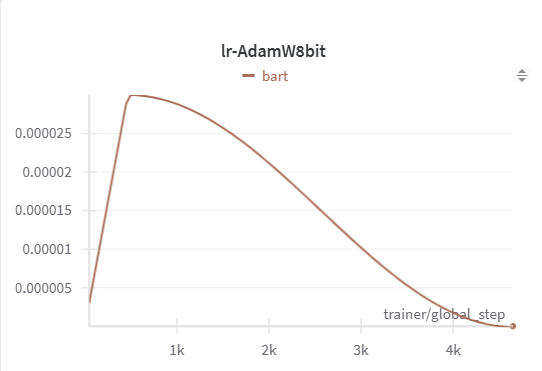

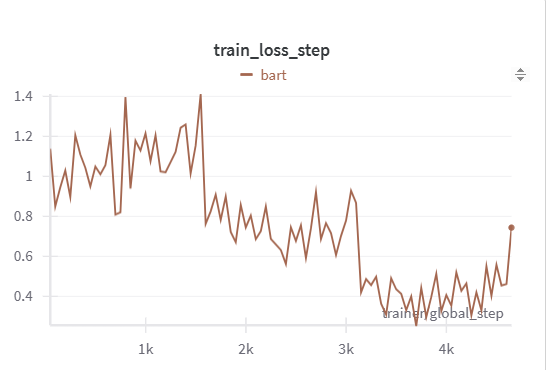

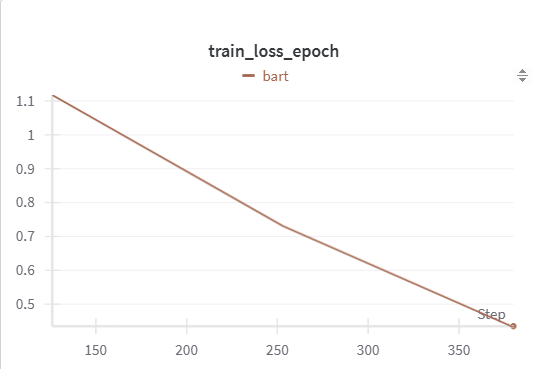

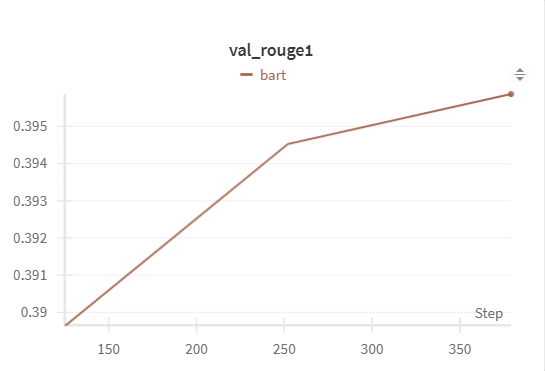

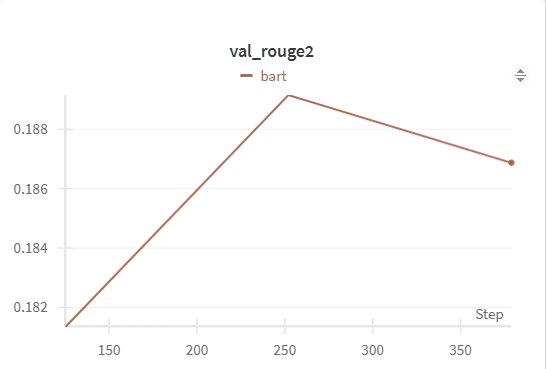

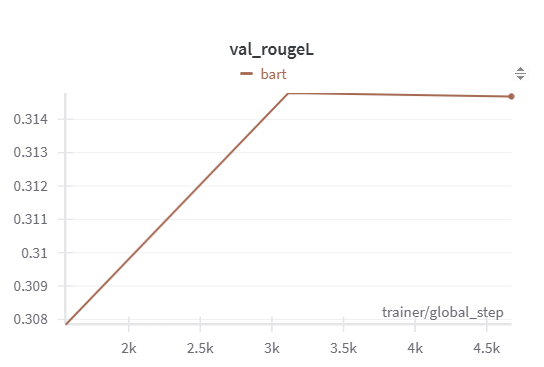

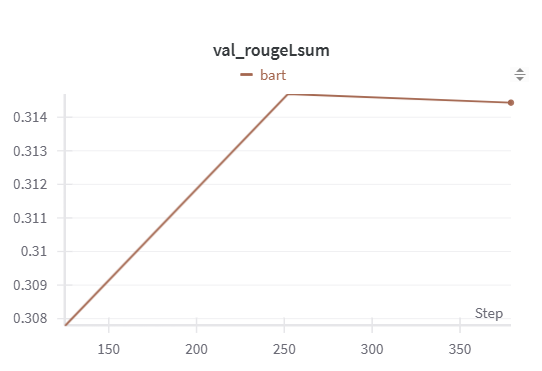

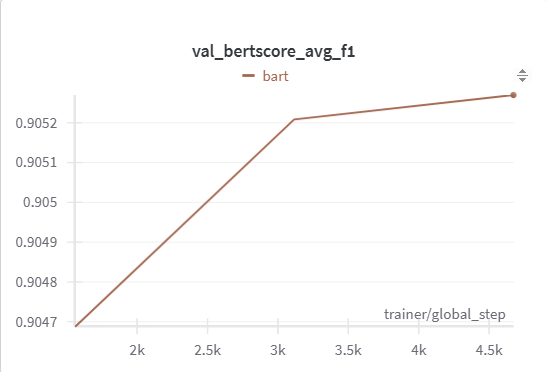

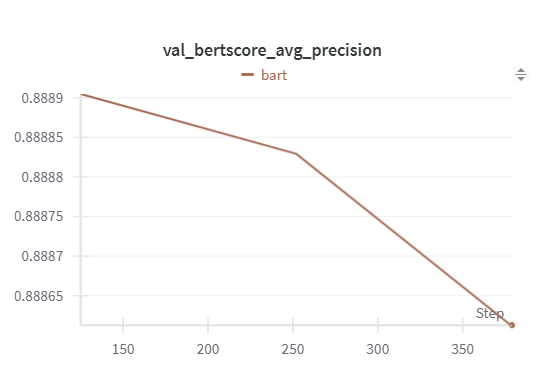

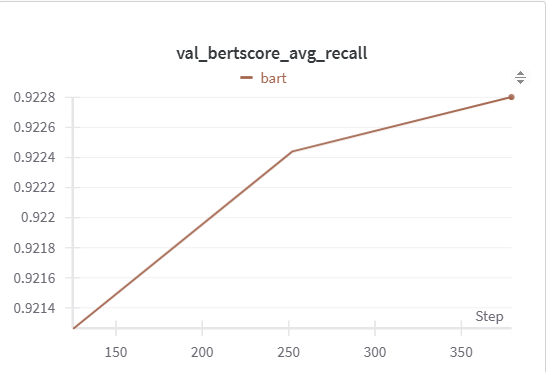

# Evaluation

In [ ]:
# Evaluate after fine-tuning
model, train_loader, val_loader = accelerator.prepare(bart_model, train_loader, val_loader)
predictions, references = evaluate_model(model, tokenizer, val_loader, max_tgt, accelerator)
results = compute_metrics(predictions, references)

predictions, references = evaluate_model(bart_model, tokenizer, val_loader, max_tgt, accelerator)
results = compute_metrics(predictions, references)
print("Zero-shot results:")
print(zs_results)
print("Results after train:")
print(results)

  0%|          | 0/63 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/63 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Zero-shot results:
{'rouge': {'rouge1': 0.2868, 'rouge2': 0.0912, 'rougeL': 0.2133, 'rougeLsum': 0.2133}, 'bertscore': {'avg_precision': 0.858, 'avg_recall': 0.8753, 'avg_f1': 0.8663}}
Results after train:
{'rouge': {'rouge1': 0.3963, 'rouge2': 0.1878, 'rougeL': 0.3147, 'rougeLsum': 0.3147}, 'bertscore': {'avg_precision': 0.8885, 'avg_recall': 0.9228, 'avg_f1': 0.9052}}


In [ ]:
print("Predictions after train")
for pred in predictions[:10]:
    print(pred)
    print()

Predictions after train
#Person2# has trouble breathing lately. #Person1# asks about the symptoms and will send him to a pulmonary specialist who can run tests on him for asthmatic, which happens a lot when he works out, for further examination and treatment. The doctor's satisfied with the service.

#Person1# and Jimmy are going to do a workout later today. They will work out on arms and stomach first. Then they will switch to legs on Friday. Jimmy will meet #Person2# at the gym at 3:30 to go together. #Person

#Person1# needs to stop eating unhealthy foods. #Person2# has started eating better and sticks to fruits, vegetables, and chicken instead of other kinds of food, which sounds a lot healthier to #Person3# and #Person4#, respectively. They are both surprised.

#Person2# believes in UFOs and tells #Person1# their task is to send the aliens here from the outer space. They look like robots but they can speak. They learn English on Mars too. #Person3# thinks it's fantastic! #Person4#